In [1]:
from tqdm.auto import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from copy import deepcopy

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/ships/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read configuration file
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==4:
    target='DELV24'

# Create Pandas DataFrame

In [3]:
# Process the filted TC list in the config file
TC_tofilt_list = ast.literal_eval(config_set['TCfilt'])
# Get the names of the remaining TCs
filt_TClist = read_vars.remove_storms(trackpath=config_set['track_path'],basinID='NA',yearmin=int(config_set['start_year']),yearmax=int(config_set['end_year']),
                                      remove_set=TC_tofilt_list)
# Read saved SHIPS csvs
storeSHIPS = read_vars.read_SHIPS_csv(startyear=int(config_set['start_year']),endyear=int(config_set['end_year']),vars_path=config_set['vars_path'],
                                      filted_TCnames=filt_TClist,suffixlist=['newships_dev_POT'])
# Read selected variables from the pandas dfs
SHIPS_df = read_vars.create_SHIPS_df(startyear=int(config_set['start_year']),endyear=int(config_set['end_year']),SHIPSdict=storeSHIPS,
                                     wantvarnames=config_set['SHIPSops_varname'],targetname=target,filted_TCnames=filt_TClist,
                                     lagnum=int(config_set['target_lag'])
                                    )
# Add derived variables stored separately
store_dfstorms_ships = read_vars.add_derive_df(startyear=int(config_set['start_year']),
                                     endyear=int(config_set['end_year']),
                                     SHIPSdict=SHIPS_df,
                                     addfilepath='/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/SHIPS/ships_pkl/all_storms_ships23vars_obswmax.pkl',
                                     addvarname=['pc20'],
                                     filted_TCnames=filt_TClist,
                                     lagnum=int(config_set['target_lag'])
                                    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 598.71it/s]
22it [00:00, 46.73it/s]
22it [00:00, 120.41it/s]
22it [00:00, 154.70it/s]


In [4]:
var_names=store_dfstorms_ships[2001]['ALLISON'].columns.values.tolist()

TC_fulllist = {}
for year in np.linspace(int(config_set['start_year']),int(config_set['end_year']),int(config_set['end_year'])-int(config_set['start_year'])+1):
    temp = store_dfstorms_ships[year]
    for ind,name in enumerate(temp.keys()):
        TC_fulllist[str(int(year))+'_'+name] = temp[name]

# ML-ready dataset

In [5]:
# Split data with a 0.15 test, 0.15 valid split
datastorer = proc_dataset.splitdata_handler(df=TC_fulllist,method='year',seed=41,config=config_set,testyears=[2020,2021])

# Remove empty storms in the data
traincleaned = {key: datastorer['train'][key] for ind,key in enumerate(datastorer['train'].keys()) if datastorer['train'][key].shape[0]>0}
validcleaned = {key: datastorer['valid'][key] for ind,key in enumerate(datastorer['valid'].keys()) if datastorer['valid'][key].shape[0]>0}
testcleaned = {key: datastorer['test'][key] for ind,key in enumerate(datastorer['test'].keys()) if datastorer['test'][key].shape[0]>0}

# Replace original training data with the cleaned version
datastorer_n = deepcopy(datastorer)

# Replace
datastorer_n['train'] = traincleaned
datastorer_n['valid'] = validcleaned
datastorer_n['test'] = testcleaned

In [6]:
# Get smoothed MSLP data and argmin values
smoothed_MSLP, MSLP_argmin = proc_dataset.proc_data(df=datastorer_n,
                                                    seed=42).smooth_and_minindices(varname='MSLP',sigma=3)
# Aligned the inputs with the minimum SLP data
aligned_train = proc_dataset.proc_data(df=datastorer_n,seed=42).do_data_align(datastorer_n['train'],MSLP_argmin['train'],var_names)
aligned_valid = proc_dataset.proc_data(df=datastorer_n,seed=42).do_data_align(datastorer_n['valid'],MSLP_argmin['valid'],var_names)
aligned_test = proc_dataset.proc_data(df=datastorer_n,seed=42).do_data_align(datastorer_n['test'],MSLP_argmin['test'],var_names)

# Combine different TCs into a long dataset
X,y,size = proc_dataset.df_proc_separate(aligned_train,aligned_valid,aligned_test,target)

In [7]:
# Find the mean and std of the training set for normalization
trainmean,trainstd = X['train'].dropna().mean(axis=0),X['train'].dropna().std(axis=0)

# Data normalization
Xnorml = proc_dataset.normalized_TCs_handler(train=aligned_train,
                                             valid=aligned_valid,
                                             test=aligned_test,
                                             trainmean=trainmean,
                                             trainstd=trainstd,
                                             dropcol=['DELV24'],
                                             target=target
                                            )
var_names = Xnorml['train'][list(Xnorml['train'].keys())[0]].columns

# Causal

In [15]:
onlyships_lag = causal_settings.link_onlyships(numvar=aligned_train[list(aligned_train.keys())[0]].shape[1],
                                               lag=int(config_set['target_lag']),
                                               target_ind=[0])

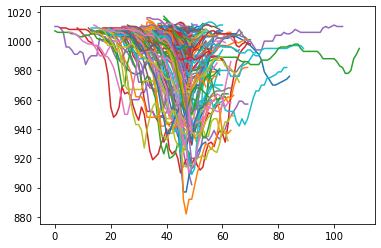

In [53]:
for key in aligned_train.keys():
    plt.plot(np.ma.masked_less(aligned_train[key][:,2],800))
#plt.ylim(0,1010)
plt.show()

In [17]:
Xnorml_c = {'train': {ind: np.asarray(Xnorml['train'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['train'].keys())},
            'valid': {ind: np.asarray(Xnorml['valid'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['valid'].keys())},
            'test': {ind: np.asarray(Xnorml['test'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['test'].keys())}
           }

for pc_alpha in tqdm([0.1]):#[0.09]):#,0.07,0.05,0.01,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]):#np.linspace(0.9,0.99,10)):#,0.1,0.05,0.01,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]):
    result = train_PC1.Pipeline(Xnorml_c['train'],
                                pc_alpha,
                                pc_type='run_pcstable',
                                tau_min0=int(config_set['tau_min']),
                                tau_max0=int(config_set['tau_max']),
                                var_name=var_names,
                                link_assumptions=onlyships_lag).run_tigramite()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]
